In [1]:
import torch
import torch.nn as nn

In [2]:
from tqdm.auto import tqdm

/Users/matiasmolinolo/anaconda3/envs/iag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
in_size = 28*28
hidden_size = 500

In [4]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x >= 0.5).float(),
])

original_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
original_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

filter_digit = 6

filtered_train_dataset = [item for item in original_train_dataset if item[1] == filter_digit]
filtered_test_dataset = [item for item in original_test_dataset if item[1] == filter_digit]

filtered_dataset = filtered_train_dataset + filtered_test_dataset

data_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=True, num_workers=2, multiprocessing_context='fork')

In [6]:
import matplotlib.pyplot as plt

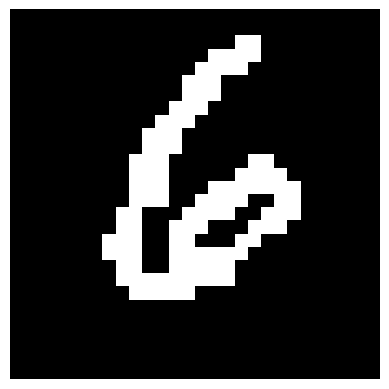

In [7]:
plt.imshow(filtered_dataset[0][0].squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [9]:
class NADE(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(NADE, self).__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size

        self.W_h = nn.Parameter(torch.randn(self.hidden_size, self.input_dim)) #hidden
        self.b_h = nn.Parameter(torch.randn(self.hidden_size)) #hidden bias

        self.W_out = nn.Parameter(torch.randn(self.input_dim, self.hidden_size)) #out
        self.b_out = nn.Parameter(torch.randn(self.input_dim)) #out bias

    def forward(self, x):
        batch_size = x.shape[0]

        a = self.b_h

        probs = torch.zeros(batch_size, self.input_dim)

        for i in range(self.input_dim):
            h_d = torch.sigmoid(a).reshape(-1, self.hidden_size)
            probs[:, i] = torch.sigmoid((self.W_out[i] @ h_d.t()) + self.b_out[i]).flatten()
            a = (self.W_h[:,i].reshape(-1,1) @ x[:,i].reshape(1,-1)).reshape(-1,self.hidden_size) + a

        return probs

In [10]:
nade = NADE(in_size, hidden_size).to(device)

In [11]:
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(nade.parameters(), lr=0.001)

In [12]:
from timeit import default_timer as timer

epochs = 40
for epoch in range(epochs):
    t0 = timer()
    epoch_loss = 0
    for batch, (data, _) in enumerate(tqdm(data_loader)):
        data = data.view(-1, in_size).to(device)

        optimizer.zero_grad()
        output = nade(data)
        loss = criterion(output.to(device), data)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    t1 = timer()
    print(f'Epoch: {epoch + 1}, Loss: {epoch_loss/len(data_loader)}, Time taken: {(t1 - t0):.2f} s')

 25%|██▌       | 27/108 [01:37<04:51,  3.59s/it]


KeyboardInterrupt: 

In [ ]:
def sample(model, input_dim, device):
  with torch.no_grad():
    preds = torch.zeros(1, input_dim).to(device)
    for i in tqdm(range(input_dim)):
        p = model.forward(preds)
        preds[0][i] = torch.bernoulli(p[0][i])

    return torch.reshape(preds.cpu(), (28, 28))

In [ ]:
torch.save(nade, 'nade.pt')

In [ ]:
img = sample(nade, in_size, device)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def show_sample(img):
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
show_sample(img)